In [32]:
import pandas as pd
from bisect import bisect
import numpy as np
import eddington
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [10,7.5]
plt.rcParams.update({'font.size': 18, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [33]:
def equaliser(x,y,nun):
    eq_x = np.linspace(x[0],x[-1],nun)
    eq_y = []
    for point in eq_x:
        i = bisect(x,point)
        if i == len(x):
            eq_y.append(y[i-1])
            continue
        eq_y.append((y[i]-y[i-1])/(x[i]-x[i-1])*(point-x[i-1]) + y[i-1]) 
        # an interpolation function can be written instead to use more advanced interpolation methods
    return [eq_x , eq_y]

def avg(y):
    return sum(y)/len(y)

def findPeaks(x,y, maxPik, minDis, win=2):
    peaks = []
    for i in range(win,len(y)-win):
        pik = True
        for j in range(1,win):
            if y[i-j] > y[i-j+1] or y[i+j] > y[i+j-1]:
                pik = False
                break
                
        if pik:
            peaks.append(i)
        
    for j in range(10):
        i=0
        while i < len(peaks)-1:
            rm = False
            if y[peaks[i]] < maxPik or \
            y[peaks[i]]<y[peaks[i+1]]/2 or \
            x[peaks[i+1]]-x[peaks[i]]<minDis*(x[peaks[i]+3]-x[peaks[i]])/2.5 or \
            peaks[i+1]-peaks[i] < minDis:
                rm = True
            
            if rm:
                if y[peaks[i+1]]>y[peaks[i]]:
                    peaks[i] = None
                else:
                    peaks[i+1] = None
                    i+=1
            i+=1

        while None in peaks: peaks.remove(None)
    
    dist = [x[peaks[i+1]]-x[peaks[i]] for i in range(len(peaks)-1)]
    
    i=0
    while i<len(dist):
        if dist[i]>1.2*avg(dist):
            break
        i+=1
        
    peaks = peaks[:i+2]
    peaks = np.array([[x[i],y[i]] for i in peaks]).T
    return peaks

def TwinPeaks(x,y,start):
    # assuming len(x)==len(y)
    i=0
    mins=[]
    while i<len(x) and len(mins)<start+4:
        if y[i-2] > y[i] and y[i-1] > y[i] and y[i+1] > y[i] and y[i+2] > y[i] and y[i]<0.5:
            mins.append(i)
        i+=1
        if len(mins)>1 and mins[-1]==mins[-2]:
            del mins[-1]
    return mins[start+1:]

def func1(x,a,b,c):
    return a*np.exp(-b*x)*c*x/np.sinh(c*x)

def printFloat(lst):
    printed = '['
    for item in lst[:-1]:
        printed += f'{item:.4f}, '
    printed += f'{lst[-1]:.4f}]'
    return printed

In [34]:
@eddington.fitting_function(
    n=3,
    a_derivative=lambda a, x: np.stack([np.exp(-a[1]*x)*a[2]*x/np.sinh(a[2]*x),
                                        -a[0]*x*np.exp(-a[1]*x)*a[2]*x/np.sinh(a[2]*x),
                                        x*np.exp(-a[1]*x)*a[2]*(1/np.sinh(a[2]*x)-a[2]*x/(np.sinh(a[2]*x)*np.tanh(a[2]*x))),
                                        ]),
    syntax="a[0]*np.exp(-a[1]*x)*a[2]*x/np.sinh(a[2]*x)")
def Outer(a,x):
    return a[0]*np.exp(-a[1]*x)*x/np.sinh(a[2]*x)

FittingFunctionSaveError: Cannot save "Outer" to registry since there is another fitting function with this name

In [36]:
@eddington.fitting_function(
    n=2,
    a_derivative=lambda a, x: np.stack([np.exp(-a[1]*x)*x/np.sinh(1.854*x),
                                        -a[0]*x*np.exp(-a[1]*x)*x/np.sinh(1.854*x),
                                        ]),
    syntax="a[0]*np.exp(-a[1]*x)*a[2]*x/np.sinh(a[2]*x)")
def Outer17(a,x):
    return a[0]*np.exp(-a[1]*x)*x/np.sinh(1.854*x)

@eddington.fitting_function(
    n=2,
    a_derivative=lambda a, x: np.stack([np.exp(-a[1]*x)*x/np.sinh(4.2/1.7*1.854*x),
                                        -a[0]*x*np.exp(-a[1]*x)*x/np.sinh(4.2/1.7*1.854*x),
                                        ]),
    syntax="a[0]*np.exp(-a[1]*x)*a[2]*x/np.sinh(a[2]*x)")
def Outer42(a,x):
    return a[0]*np.exp(-a[1]*x)*x/np.sinh(4.2/1.7*1.854*x)

FittingFunctionSaveError: Cannot save "Outer17" to registry since there is another fitting function with this name

In [35]:
files = ["B=5.5to0_T=4.2_Vg=0.5.xlsx","B=0to5.5_T=4.2_Vg=0.xlsx","B=0to5.5_T=4.2_Vg=-0.5.xlsx",
         "B=0to5.5_T=1.7_Vg=0.5.xlsx", "B=5.5to0_T=1.7_Vg=0.xlsx", "B=0to5.5_T=1.7_Vg=-0.5.xlsx"]
minField = 1/1.25
data = [pd.read_excel(file) for file in files]
directions = [int(np.sign(df['Field 1 '][1]-df['Field 1 '][0])) for df in data]
datamin = [[data[i]['Field 1 '][data[i]['Field 1 ']<minField].to_list(),data[i]['SR510 No. 1 (Ohm}'][data[i]['Field 1 ']<minField].to_list()] for i in range(len(data))]
data = [[data[i]['Field 1 '][data[i]['Field 1 ']>minField].to_list(),data[i]['SR510 No. 1 (Ohm}'][data[i]['Field 1 ']>minField].to_list()] for i in range(len(data))]
data = [np.array([data[i][0][::directions[i]],data[i][1][::directions[i]]]) for i in range(len(data))]
datamin = [np.array([datamin[i][0][::directions[i]],datamin[i][1][::directions[i]]]) for i in range(len(datamin))]
names = [r'$\text{V}_{\text{g}}$=0.5 [Volt], T=4.2 [Kelvin]',
         r'$\text{V}_{\text{g}}$=0 [Volt], T=4.2 [Kelvin]',
         r'$\text{V}_{\text{g}}$=-0.5 [Volt], T=4.2 [Kelvin]',
         r'$\text{V}_{\text{g}}$=0.5 [Volt], T=1.7 [Kelvin]',
         r'$\text{V}_{\text{g}}$=0 [Volt], T=1.7 [Kelvin]',
         r'$\text{V}_{\text{g}}$=-0.5 [Volt], T=1.7 [Kelvin]']
filenames = ['Vg=0.5_T=4.2','Vg=0_T=4.2','Vg=-0.5_T=4.2','Vg=0.5_T=1.7','Vg=0_T=1.7','Vg=-0.5_T=1.7']

minn = min([min(df[1]) for df in data])
maxx = max([len(df[1]) for df in data])
d = 5/maxx
data = np.array([equaliser(df[0],df[1],maxx) for df in data])

[0.1877, 0.2464, 0.3141, 0.3860, 0.4540, 0.5263, 0.5966, 0.6703, 0.7387, 0.8096, 0.8799, 0.9516, 1.0220, 1.0957]
tauQ*10^12=1.185449\pm0.198510
Results:

Initial parameters' values:
	149.55555555555554 1.183206106870229
Fitted parameters' values:
	a[0] = 1795.9 ± 146.5 (8.160% error)
	a[1] = 1.1182 ± 0.1872 (16.75% error)
Fitted parameters covariance:
[[1.385e+04 1.568e+01]
 [1.568e+01 2.261e-02]]
Chi squared: 18.61
Degrees of freedom: 12
Chi squared reduced: 1.550
P-probability: 0.09850



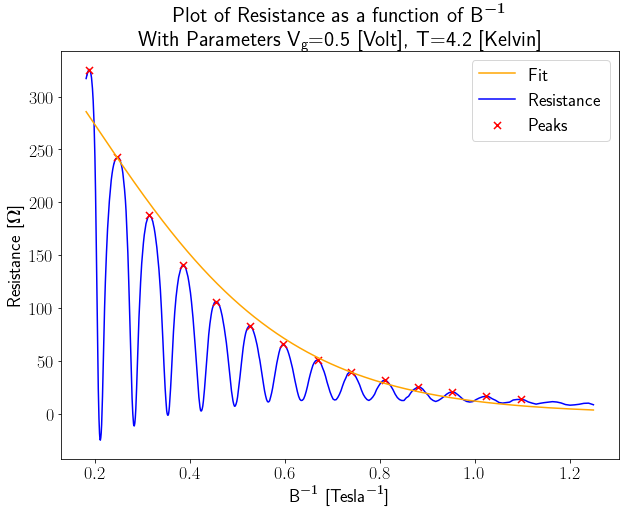

[0.2567, 0.3616, 0.4628, 0.5641, 0.6681, 0.7695, 0.8759, 0.9771, 1.0813, 1.1821]
tauQ*10^12=0.545229\pm0.026053
Results:

Initial parameters' values:
	311.9111111111111 1.183206106870229
Fitted parameters' values:
	a[0] = 3914.5 ± 194.3 (4.964% error)
	a[1] = 2.4312 ± 0.1162 (4.778% error)
Fitted parameters covariance:
[[2.753e+05 1.517e+02]
 [1.517e+02 9.838e-02]]
Chi squared: 1.097
Degrees of freedom: 8
Chi squared reduced: 0.1372
P-probability: 0.9976



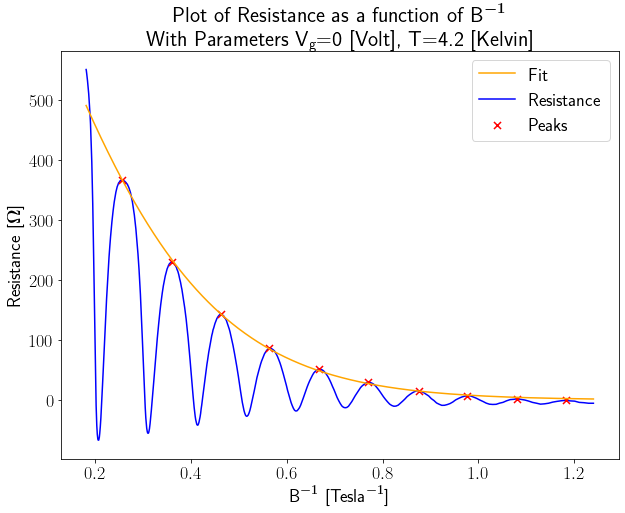

[0.2282, 0.4039, 0.5749, 0.7436, 0.9024, 1.0522]
tauQ*10^12=1.038376\pm0.166127
Results:

Initial parameters' values:
	950.0444444444445 1.183206106870229
Fitted parameters' values:
	a[0] = 9176.1 ± 802.6 (8.747% error)
	a[1] = 1.2766 ± 0.2042 (16.00% error)
Fitted parameters covariance:
[[9.539e+05 2.146e+02]
 [2.146e+02 6.177e-02]]
Chi squared: 2.701
Degrees of freedom: 4
Chi squared reduced: 0.6753
P-probability: 0.6090



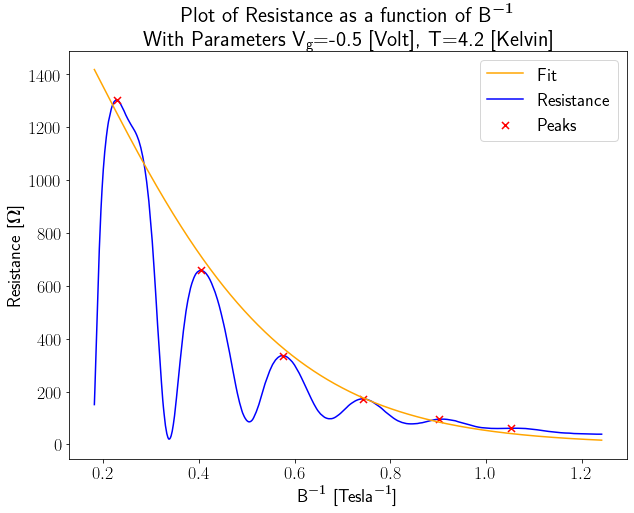

[0.1879, 0.2480, 0.3121, 0.3838, 0.4523, 0.5259, 0.5983, 0.6695, 0.7413, 0.8127, 0.8784, 0.9439, 1.0131, 1.0854, 1.2254]
tauQ*10^12=0.368409\pm0.009371
Results:

Initial parameters' values:
	143.9111111111111 1.183206106870229
Fitted parameters' values:
	a[0] = 1176.25 ± 47.10 (4.005% error)
	a[1] = 3.59801 ± 0.09152 (2.544% error)
Fitted parameters covariance:
[[6.330e+03 1.080e+01]
 [1.080e+01 2.389e-02]]
Chi squared: 4.557
Degrees of freedom: 13
Chi squared reduced: 0.3505
P-probability: 0.9837



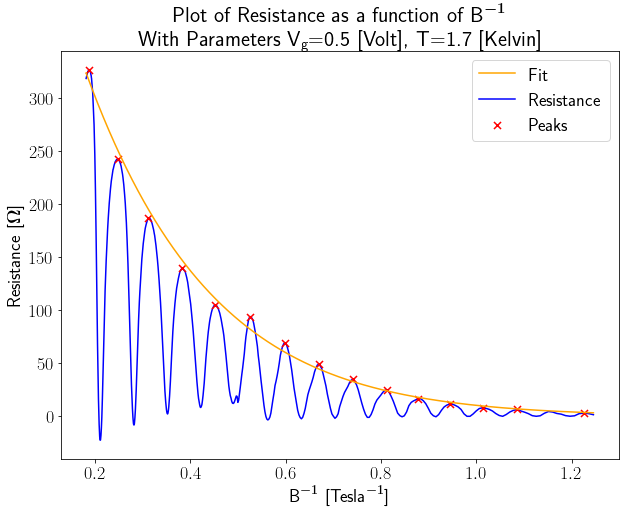

[0.2390, 0.2774, 0.3628, 0.4620, 0.5672, 0.6696, 0.7716, 0.8737, 0.9808, 1.0782, 1.1877]
tauQ*10^12=0.447776\pm0.016098
Results:

Initial parameters' values:
	304.26666666666665 1.183206106870229
Fitted parameters' values:
	a[0] = 1703.14 ± 83.58 (4.908% error)
	a[1] = 2.9603 ± 0.1064 (3.595% error)
Fitted parameters covariance:
[[1.749e+04 1.981e+01]
 [1.981e+01 2.835e-02]]
Chi squared: 3.595
Degrees of freedom: 9
Chi squared reduced: 0.3995
P-probability: 0.9360



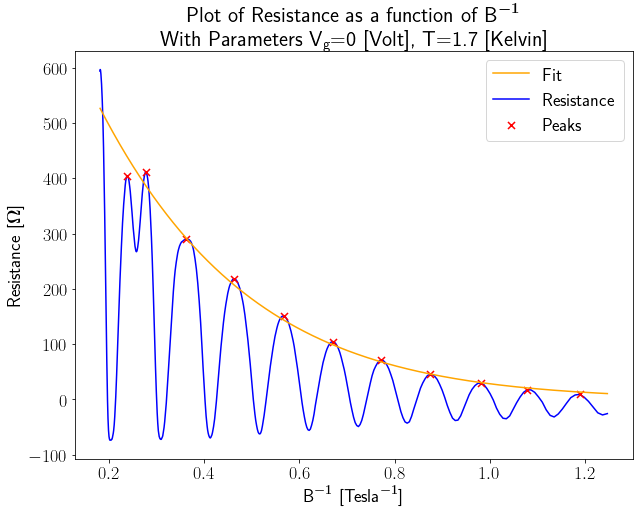

[0.2256, 0.2879, 0.4143, 0.5871, 0.7605, 0.9332, 1.1105]
tauQ*10^12=0.415551\pm0.003573
Results:

Initial parameters' values:
	1001.2 1.183206106870229
Fitted parameters' values:
	a[0] = 5863.55 ± 66.58 (1.135% error)
	a[1] = 3.18984 ± 0.02742 (0.8597% error)
Fitted parameters covariance:
[[2.819e+05 1.028e+02]
 [1.028e+02 4.783e-02]]
Chi squared: 0.07862
Degrees of freedom: 5
Chi squared reduced: 0.01572
P-probability: 0.9999



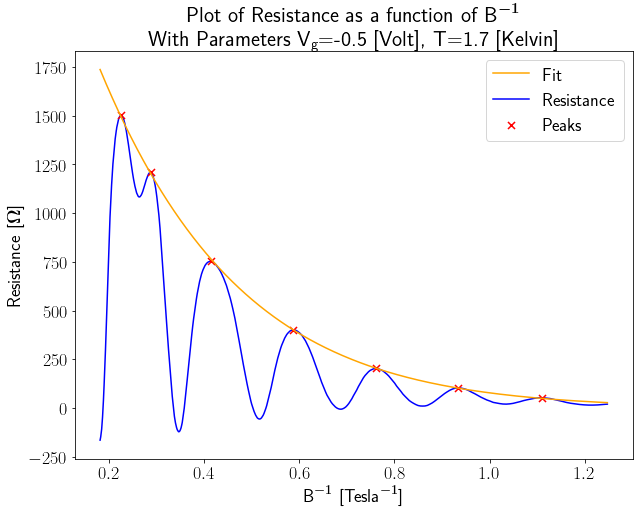

In [38]:
oneOver = np.array([[1/x for x in df[0]][::-1] for df in data])
e=1.602176634*10**(-19)
R0=[]
mStar = 6.7601*10**(-32)
for i in range(len(data)):
    Bindex = int(0.3//(data[i][0][1]-data[i][0][0]))
    R0.append(avg(datamin[i][1][:Bindex]))
    
    peaks = findPeaks(oneOver[i], data[i][1][::-1], avg(data[i][1][::-1])/10, 8, win=2)
    print(printFloat(peaks[0]))
    pikData = eddington.FittingData(dict(x=peaks[0], dx=0.05*peaks[0], y=peaks[1]-R0[-1], dy=0.05*(peaks[1])))

    guess=[4*R0[-1], 1*3.1*10**(12)/(2.62*10**(12))]
    if 'T=1.7' in filenames[i]:
        pikRe=eddington.fit(pikData, Outer17, a0=guess)
        outside = np.array(Outer17(pikRe.a,oneOver[i]))
    else:
        pikRe=eddington.fit(pikData, Outer42, a0=guess)
        outside = np.array(Outer42(pikRe.a,oneOver[i]))
    tauq=(np.pi*mStar)/(e*pikRe.a[1])
    dtauq=tauq*pikRe.aerr[1]/pikRe.a[1]
    print(f'tauQ*10^12={tauq/10**(-12):.6f}\pm{dtauq/10**(-12):.6f}')
    print(pikRe)

#     if i<3:
#         mStar = pikRe.a[2]/(4.2*2*np.pi**2*1.38*10**(-23)/(1.054*10**(-34)*e))
#         dmStar = pikRe.aerr[2]/(4.2*2*np.pi**2*1.38*10**(-23)/(1.054*10**(-34)*e))
#         tauq=(np.pi*mStar)/(e*pikRe.a[1])
#         dtauq=tauq*np.sqrt((mStar/dmStar)**2+(pikRe.a[1]/pikRe.aerr[1])**2)
#     else:
#         mStar = pikRe.a[2]/(1.7*2*np.pi**2*1.38*10**(-23)/(1.054*10**(-34)*e))
#         dmStar = pikRe.aerr[2]/(1.7*2*np.pi**2*1.38*10**(-23)/(1.054*10**(-34)*e))
#         tauq=(np.pi*mStar)/(e*pikRe.a[1])
#         dtauq=tauq*np.sqrt((mStar/dmStar)**2+(pikRe.a[1]/pikRe.aerr[1])**2)
#     print(f'm={mStar/10**(-32):.6f}\pm{dmStar/10**(-32):.3f}')
#     print(f'tq={tauq/10**(-12):.6f}\pm{dtauq/10**(-12):.4f}')
    
    plt.plot(oneOver[i],outside,c='orange',label='Fit')
    plt.scatter(peaks[0], peaks[1]-R0[-1], label='Peaks', zorder=1, c='r', marker='x',s=50)
    plt.plot(oneOver[i],data[i][1][::-1]-R0[-1], label='Resistance', zorder=0, c='b')
    plt.title(r'Plot of Resistance as a function of $\text{B}^{\boldsymbol{-1}}$'+f'\nWith Parameters {names[i]}')
    plt.ylabel(r'Resistance [$\boldsymbol{\Omega}$]')
    plt.xlabel(r'$\text{B}^{\boldsymbol{-1}}$ [$\text{Tesla}^{\boldsymbol{-1}}$]')
    plt.legend()
    plt.savefig(f'Peaks/PeaksPlot_{filenames[i]}.png')
    plt.show()
    

In [ ]:
@eddington.fitting_function(
    n=3,
    syntax="a[0]*np.sinh(a[1]*(x-a[2]))/np.sinh(a[3]*(x-a[2]))*np.exp(a[4]*(x-a[2]))")
def factorFun(a,x):
    return a[0]*np.sinh(a[1]*(x))/np.sinh(4.2/1.7*a[1]*(x))*np.exp(a[2]*(x))

In [17]:
@eddington.fitting_function(
    n=4,
    syntax="0.88*np.sinh(a[0]*(x-a[1]))/np.sinh(a[2]*(x-a[1]))*np.exp(a[3]*(x-a[1]))")
def factorFunNot1(a,x):
    return 0.88*np.sinh(a[0]*(x-a[1]))/np.sinh(a[2]*(x-a[1]))*np.exp(a[3]*(x-a[1]))
@eddington.fitting_function(
    n=4,
    syntax="a[0]*np.sinh(a[1]*(x-0.5871))/np.sinh(a[2]*(x-0.5871))*np.exp(a[3]*(x-0.5871))")
def factorFunNot2(a,x):
    return a[0]*np.sinh(a[1]*(x-0.5871))/np.sinh(a[2]*(x-0.5871))*np.exp(a[3]*(x-0.5871))

[0.1877, 0.2464, 0.3141, 0.3860, 0.4540, 0.5263, 0.5966, 0.6703, 0.7387, 0.8096, 0.8799, 0.9516, 1.0220, 1.0957]
[0.1879, 0.2480, 0.3121, 0.3838, 0.4523, 0.5259, 0.5983, 0.6695, 0.7413, 0.8127, 0.8784, 0.9439, 1.0131, 1.0854, 1.2254]
Results:

Initial parameters' values:
	1.22 1.0 -1.0
Fitted parameters' values:
	a[0] = 2.1514 ± 0.1850 (8.600% error)
	a[1] = -1.1715 ± 0.2868 (24.48% error)
	a[2] = 0.8323 ± 0.4368 (52.48% error)
Fitted parameters covariance:
[[ 0.003  0.004 -0.007]
 [ 0.004  0.007 -0.011]
 [-0.007 -0.011  0.017]]
Chi squared: 113.9
Degrees of freedom: 10
Chi squared reduced: 11.39
P-probability: 8.604e-20

mass17=4.2724\pm1.0458


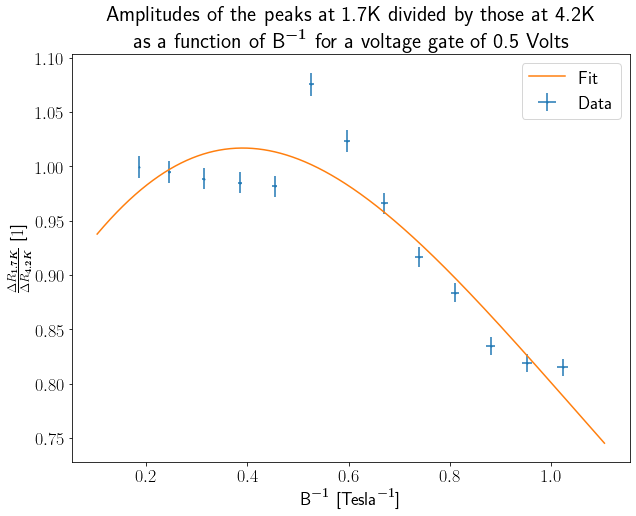

[0.2567, 0.3616, 0.4628, 0.5641, 0.6681, 0.7695, 0.8759, 0.9771, 1.0813, 1.1821]
[0.2390, 0.2774, 0.3628, 0.4620, 0.5672, 0.6696, 0.7716, 0.8737, 0.9808, 1.0782, 1.1877]
Results:

Initial parameters' values:
	0.7 1.0 -1.0
Fitted parameters' values:
	a[0] = 1.8281 ± 0.9764 (53.41% error)
	a[1] = -1.854 ± 2.113 (114.0% error)
	a[2] = 2.377 ± 3.533 (148.6% error)
Fitted parameters covariance:
[[ 0.044  0.095 -0.159]
 [ 0.095  0.206 -0.344]
 [-0.159 -0.344  0.575]]
Chi squared: 130.3
Degrees of freedom: 6
Chi squared reduced: 21.71
P-probability: 1.125e-25

mass17=6.7601\pm7.7069


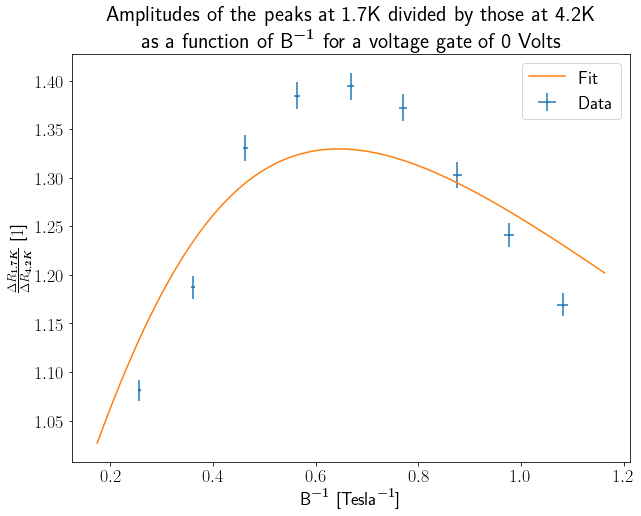

[0.2282, 0.4039, 0.5749, 0.7436, 0.9024, 1.0522]
[0.2256, 0.2879, 0.4143, 0.5871, 0.7605, 0.9332, 1.1105]
Results:

Initial parameters' values:
	0.88 1.0 1.0
Fitted parameters' values:
	a[0] = 2.7079 ± 0.1144 (4.224% error)
	a[1] = 0.5608 ± 0.1842 (32.84% error)
	a[2] = 0.1957 ± 0.1791 (91.48% error)
Fitted parameters covariance:
[[ 0.007 -0.01  -0.01 ]
 [-0.01   0.018  0.017]
 [-0.01   0.017  0.017]]
Chi squared: 3.841
Degrees of freedom: 2
Chi squared reduced: 1.920
P-probability: 0.1465

mass17=2.0453\pm0.6716


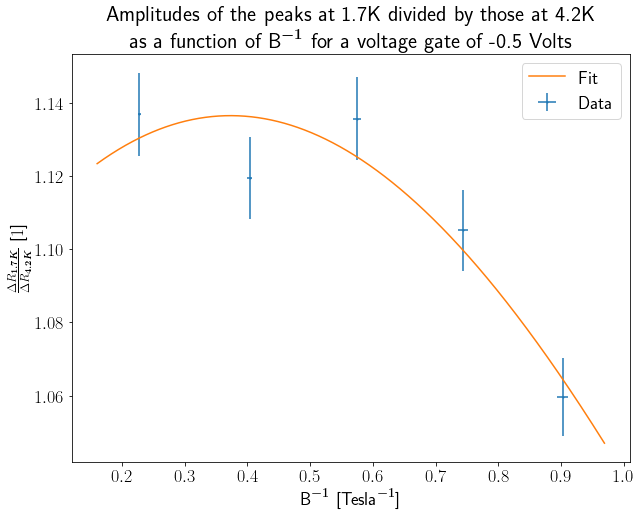

In [47]:
displacement=[0,1,1]
cuttinRoom=[-1,-1,-1]
factor=[[],[],[],[],[],[]]
ggg = 2*np.pi**2*kb*1.7/(hbar*e)
guess=np.array([
    [1.22,1,-1],
    [0.7,1,-1],
    [0.88,1,1]
])

kb=1.380649*10**(-23)
hbar=1.054571817*10**(-34)
VG=[0.5,0,-0.5]

for i in range(len(data)//2):
    peaks1 = findPeaks(oneOver[i], data[i][1][::-1], avg(data[i][1][::-1])/10, 7, win=2)
    peaks2 = findPeaks(oneOver[i+3], data[i+3][1][::-1], avg(data[i+3][1][::-1])/10, 7, win=2)
    print(printFloat(peaks1[0]))
    print(printFloat(peaks2[0]))
    
    disp = 0
    index = 2*i+1
    for j in range(len(peaks1[0])):
        
        if displacement[i] and j==displacement[i]:
            disp+=1
            
        if j+disp==len(peaks2[0]):
            break
        factor[index].append(peaks2[1][j+disp]/peaks1[1][j])
        
    factor[2*i] = list(peaks1[0][:len(factor[index])])
    factor[2*i] = np.array(factor[2*i][:cuttinRoom[i]])
    factor[index]=np.array(factor[index][:cuttinRoom[i]])
    
    factorData = eddington.FittingData(dict(x=factor[2*i], dx=0.01*factor[2*i], y=factor[index], dy=0.01*factor[index]))
    factorRe=eddington.fit(factorData, factorFun, a0=guess[i])
    eddington.plot_fitting(factorFun, factorData, a=factorRe.a, title_name='')
#     mass42=np.abs(factorRe.a[1])/(2*np.pi**2*kb*4.2/(hbar*e))
    mass17=np.abs(factorRe.a[1])/(2*np.pi**2*kb*1.7/(hbar*e))
    print(factorRe)
#     print(f'mass42={mass42*10**(32)}\pm{mass42*10**(32)*factorRe.aerr[1]/np.abs(factorRe.a[1])}')
    print(f'mass17={mass17*10**(32):.4f}\pm{mass17*10**(32)*factorRe.aerr[1]/np.abs(factorRe.a[1]):.4f}')
#     plt.scatter(factor[2*i],factor[index])
    plt.ylabel(r'$\frac{\Delta R_{\boldsymbol{1.7K}}}{\Delta R_{\boldsymbol{4.2K}}}$ [$1$]')
    plt.xlabel(r'$\text{B}^{\boldsymbol{-1}}$ [$\text{Tesla}^{\boldsymbol{-1}}$]')
    plt.title('Amplitudes of the peaks at 1.7K divided by those at 4.2K\nas a function of '+r'$\text{B}^{\boldsymbol{-1}}$'+f' for a voltage gate of {VG[i]} Volts')
    plt.legend(('Fit','Data'))
    plt.savefig(f'Factors/Vg={VG[i]}.png')
    plt.show()


for i in range(3):
    x=factor[2*i]
    y=factor[2*i+1]
    pd.DataFrame(np.array([x,0.01*x,y,0.01*y]).T,columns=['x','dx','y','dy']).set_index('x').to_excel(f'Factors/Factors_Vg={VG[i]}.xlsx')